# Google x Kaggle Gen AI Capstone Project - Simplified Youtube

## Introduction
Simplified Youtube is a way for people to get a simplified understanding of Youtube videos through the Youtube Transcript API.

## Applications
- For students, it gives them an opportunity to understand lectures at a high level. The summary and additional keywords allows for students to focus on particular concepts.
- For entertainment watchers, it gives users the chance to 


## Setup

Start by installing and importing the Python SDK

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install youtube_transcript_api


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00


In [2]:
from google import genai
from google.genai import types

from youtube_transcript_api import YouTubeTranscriptApi as yta

from IPython.display import Markdown

# genai.__version__

#### Set up your API key
To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.

To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [4]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


If you received an error response along the lines of No user secrets exist for kernel id ..., then you need to add your API key via Add-ons, Secrets and enable it.

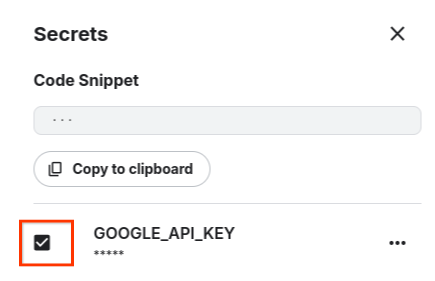



In [5]:
# sample Comp Sci lectures to get transcripts from
link = 'https://www.youtube.com/watch?v=k6U-i4gXkLM'

## get_transcript

A function used to extract a video's transcript based off of their link


In [6]:
def get_transcript(youtube_url):
    vid_id = youtube_url.split('=')[1]
    raw_transcript = yta.get_transcript(vid_id)

    transcript = ''

    for line in raw_transcript:
        transcript+=' ' + line['text']

    return transcript

In [7]:
# Get a sample transcript, courtesy of MIT 6.00 - Introduction to Computer Science and Programming, Fall 2008
transcript = get_transcript(link)

## Documenting understanding and JSON output

Now, create a prompt that leverages the model's JSON mode to produce an organized JSON output with the video's summary, 10 relevant keywords, and video tags.

In [8]:
import typing_extensions as typing

prompt = "Give me a maximum of 400 word summary, 5 video tags of relevant topics, and the top 10 relevant keywords from the following transcript:"

class YoutubeResponse(typing.TypedDict):
    summary: str
    keywords: list[str]
    tags: list[str]

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=YoutubeResponse,
    ),
    contents=prompt + transcript)

print(response.text)



    

{
  "summary": "This lecture serves as an introduction to the MIT course 6.00, Introduction to Computer Science and Programming. Professors Eric Grimson and John Guttag outline the course's strategic and tactical goals. The course aims to prepare students, especially those without prior programming experience, for further studies in computer science. It also seeks to equip non-computer science majors with the ability to confidently write and read small code snippets. The course emphasizes understanding the capabilities and limitations of computation in tackling technical problems. Students will learn to use computational thinking to write small-scale programs, understand programs written by others, and map scientific problems into a computational framework. The lecture also covers course administration, including class schedules, recitation sessions, problem sets in Python, quizzes, and grading policies. The professors stress the importance of seeking help when needed and encourage stu

## One-shot prompt

Now create a one shot prompt to create an outline from the provided video. 

In [9]:
one_shot_prompt = '''
Create an outline for the transcript provided. For lectures, this should serve as an outline for what students might have to study/focus on.

Example:
Give me an outline for the 
Outline:
1. Course Outline
2. Java variables
    - typing
3. Functions
    - return statements
'''

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=1000,
    ),
    contents=[one_shot_prompt, transcript])

print(response.text)

Okay, here's an outline of the lecture transcript, suitable for study purposes:

**Outline:**

1.  **Course Introduction**
    *   Instructors: Eric Grimson and John Guttag
    *   Course Importance:  Emphasized as a serious and important course for learning about computation.
    *   Course Goals:
        *   Administrivia
        *   Course Goals
        *   Concepts and Tools of Computational Thinking

2.  **Strategic Course Goals**
    *   Prepare freshmen/sophomores for Course 6 (EECS) entry, especially those with limited programming experience.
    *   Enable non-Course 6 majors to confidently write and read small code snippets.
    *   Provide understanding of computation's role (and limitations) in tackling technical problems.
    *   Position students to compete for internships/jobs by developing computational problem-solving skills.
    *   Targeted at students with little to no prior programming experience.

3.  **Tactical Course Goals (Skills to Acquire)**
    *   Use basic

## Topics Covered

- structured output/JSON mode/controlled generation
- document understanding
- one shot prompting